In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import classification_report, confusion_matrix , precision_recall_fscore_support
%matplotlib inline

In [95]:
DD= pd.read_excel('OnlineRetail.xlsx')

In [3]:
# élimination des valeurs manquantes
df = DD.dropna(axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [4]:
# Suppression des lignes contenant du prix ou de quantité négative
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Creation du variable TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
 8   TotalPrice   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


In [5]:
#Création d'un nouveaau Dataframe par ID clients
client_df = df.groupby('CustomerID').agg({'InvoiceDate': ['min','max', 'count'], 'TotalPrice': 'sum', 'InvoiceNo': pd.Series.nunique, 'Country': 'first'})
client_df.head()

InvoiceDate                           TotalPrice InvoiceNo  \
                           min                 max count        sum   nunique   
CustomerID                                                                      
12346.0    2011-01-18 10:01:00 2011-01-18 10:01:00     1   77183.60         1   
12347.0    2010-12-07 14:57:00 2011-12-07 15:52:00   182    4310.00         7   
12348.0    2010-12-16 19:09:00 2011-09-25 13:13:00    31    1797.24         4   
12349.0    2011-11-21 09:51:00 2011-11-21 09:51:00    73    1757.55         1   
12350.0    2011-02-02 16:01:00 2011-02-02 16:01:00    17     334.40         1   

                   Country  
                     first  
CustomerID                  
12346.0     United Kingdom  
12347.0            Iceland  
12348.0            Finland  
12349.0              Italy  
12350.0             Norway

In [6]:
# Nouveau noms pour les colonnes du client df
client_df.columns= ['premier_achat', 'dernier_achat', 'nb_article', 'CA_total','nb_facture' , 'ville' ]
client_df.head(10)


,premier_achat,dernier_achat,nb_article,CA_total,nb_facture,ville
CustomerID,,,,,,
12346.0,2011-01-18 10:01:00,2011-01-18 10:01:00,1,77183.60,1,United Kingdom
12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,182,4310.00,7,Iceland
12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,31,1797.24,4,Finland
12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00,73,1757.55,1,Italy
12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,17,334.40,1,Norway
12352.0,2011-02-16 12:33:00,2011-11-03 14:37:00,85,2506.04,8,Norway
12353.0,2011-05-19 17:47:00,2011-05-19 17:47:00,4,89.00,1,Bahrain
12354.0,2011-04-21 13:11:00,2011-04-21 13:11:00,58,1079.40,1,Spain
12355.0,2011-05-09 13:49:00,2011-05-09 13:49:00,13,459.40,1,Bahrain


R= récence
F= Fréquence
CA= Chiffre d'affaire

In [7]:
from datetime import datetime
date_reference= df['InvoiceDate'].max() + pd.Timedelta(days=1) # date du dernier facture + 1
client_df['Anciennete']= (date_reference - client_df['premier_achat']).dt.days # Ancienneté
client_df['Récence']= (date_reference - client_df['dernier_achat']).dt.days # Récence
client_df['Fréquence']= (client_df['nb_facture']) # nombre de facture
client_df.tail(10)

,premier_achat,dernier_achat,nb_article,CA_total,nb_facture,ville,Anciennete,Récence,Fréquence
CustomerID,,,,,,,,,
18273.0,2011-03-27 11:22:00,2011-12-07 13:16:00,3,204.00,3,United Kingdom,258,2,3
18274.0,2011-11-09 17:03:00,2011-11-09 17:03:00,11,175.92,1,United Kingdom,30,30,1
18276.0,2011-10-27 10:54:00,2011-10-27 10:54:00,14,335.86,1,United Kingdom,44,44,1
18277.0,2011-10-12 15:22:00,2011-10-12 15:22:00,8,110.38,1,United Kingdom,58,58,1
18278.0,2011-09-27 11:58:00,2011-09-27 11:58:00,9,173.90,1,United Kingdom,74,74,1
18280.0,2011-03-07 09:52:00,2011-03-07 09:52:00,10,180.60,1,United Kingdom,278,278,1
18281.0,2011-06-12 10:53:00,2011-06-12 10:53:00,7,80.82,1,United Kingdom,181,181,1
18282.0,2011-08-05 13:35:00,2011-12-02 11:43:00,12,178.05,2,United Kingdom,126,8,2
18283.0,2011-01-06 14:14:00,2011-12-06 12:02:00,756,2094.88,16,United Kingdom,337,4,16


Panier moyen par clients

In [8]:
client_df['Panier_moyen']= client_df['CA_total']/client_df['nb_facture'] # Chiffre d'affaire moyen par facture
client_df['Intensite_achat']= client_df['nb_facture']/(client_df['Anciennete']/30) # intensité des achat
client_df.head(10)

,premier_achat,dernier_achat,nb_article,CA_total,nb_facture,ville,Anciennete,Récence,Fréquence,Panier_moyen,Intensite_achat
CustomerID,,,,,,,,,,,
12346.0,2011-01-18 10:01:00,2011-01-18 10:01:00,1,77183.60,1,United Kingdom,326,326,1,77183.600000,0.092025
12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,182,4310.00,7,Iceland,367,2,7,615.714286,0.572207
12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,31,1797.24,4,Finland,358,75,4,449.310000,0.335196
12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00,73,1757.55,1,Italy,19,19,1,1757.550000,1.578947
12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,17,334.40,1,Norway,310,310,1,334.400000,0.096774
12352.0,2011-02-16 12:33:00,2011-11-03 14:37:00,85,2506.04,8,Norway,297,36,8,313.255000,0.808081
12353.0,2011-05-19 17:47:00,2011-05-19 17:47:00,4,89.00,1,Bahrain,204,204,1,89.000000,0.147059
12354.0,2011-04-21 13:11:00,2011-04-21 13:11:00,58,1079.40,1,Spain,232,232,1,1079.400000,0.129310
12355.0,2011-05-09 13:49:00,2011-05-09 13:49:00,13,459.40,1,Bahrain,214,214,1,459.400000,0.140187


In [9]:
# Diversité des produits achetés
diversite_produits = df.groupby('CustomerID')['StockCode'].nunique()
client_df['diversite_produits'] = diversite_produits

# Saisonnalité des achats
df['mois_achat'] = df['InvoiceDate'].dt.month
saisonnalite = df.groupby('CustomerID')['mois_achat'].agg(lambda x: x.mode()[0])
client_df['mois_prefere'] = saisonnalite

In [10]:
client_df.describe() # Statistiques descriptive

,premier_achat,dernier_achat,nb_article,CA_total,nb_facture,Anciennete,Récence,Fréquence,Panier_moyen,Intensite_achat,diversite_produits,mois_prefere
count,4338,4338,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,2011-04-30 17:06:50.857538048,2011-09-08 11:38:59.045643008,91.720609,2054.266460,4.272015,223.308207,92.536422,4.272015,419.166289,0.760803,61.501153,7.585754
min,2010-12-01 08:26:00,2010-12-01 09:53:00,1.000000,3.750000,1.000000,1.000000,1.000000,1.000000,3.450000,0.080214,1.000000,1.000000
25%,2011-01-17 11:13:15,2011-07-20 19:18:00,17.000000,307.415000,1.000000,113.000000,18.000000,1.000000,178.625000,0.232784,16.000000,5.000000
50%,2011-04-05 09:52:30,2011-10-20 10:40:30,41.000000,674.485000,2.000000,249.000000,51.000000,2.000000,293.900000,0.447761,35.000000,9.000000
75%,2011-08-19 10:11:30,2011-11-22 11:05:45,100.000000,1661.740000,5.000000,327.000000,142.000000,5.000000,430.113750,0.813192,77.000000,11.000000
max,2011-12-09 12:16:00,2011-12-09 12:50:00,7847.000000,280206.020000,209.000000,374.000000,374.000000,209.000000,84236.250000,30.000000,1787.000000,12.000000
std,NaN,NaN,228.785094,8989.230441,7.697998,117.886471,100.014169,7.697998,1796.537944,1.414964,85.366768,3.478071


In [11]:
client_df.sample(10)

,premier_achat,dernier_achat,nb_article,CA_total,nb_facture,ville,Anciennete,Récence,Fréquence,Panier_moyen,Intensite_achat,diversite_produits,mois_prefere
CustomerID,,,,,,,,,,,,,
14457.0,2011-02-02 09:39:00,2011-02-02 09:39:00,4,113.64,1,United Kingdom,311,311,1,113.640,0.096463,4,2
17772.0,2011-11-29 10:57:00,2011-11-29 11:05:00,53,182.77,2,United Kingdom,11,11,2,91.385,5.454545,50,11
16982.0,2011-10-10 12:28:00,2011-10-10 12:28:00,22,384.06,1,United Kingdom,61,61,1,384.060,0.491803,22,10
14981.0,2011-04-07 13:45:00,2011-04-07 13:45:00,8,102.12,1,United Kingdom,246,246,1,102.120,0.121951,8,4
16056.0,2011-10-25 15:19:00,2011-10-25 15:19:00,68,664.85,1,United Kingdom,45,45,1,664.850,0.666667,66,10
13726.0,2011-08-31 11:06:00,2011-11-01 10:49:00,42,1079.66,2,United Kingdom,101,39,2,539.830,0.594059,39,8
16510.0,2010-12-02 13:39:00,2010-12-02 13:39:00,13,248.10,1,United Kingdom,372,372,1,248.100,0.080645,13,12
13228.0,2011-09-19 14:28:00,2011-09-19 14:28:00,2,358.00,1,United Kingdom,81,81,1,358.000,0.370370,2,9
15462.0,2011-06-05 15:36:00,2011-09-06 13:11:00,11,234.60,3,United Kingdom,187,94,3,78.200,0.481283,9,6


Normalisation et prétraitement des données

In [66]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Normalisation
scaler = StandardScaler()
features = ['Récence','Fréquence','CA_total','Panier_moyen','diversite_produits']
X_scaled = scaler.fit_transform(client_df[features])

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # Réduction à 2D pour visualisation
X_pca = pca.fit_transform(X_scaled)

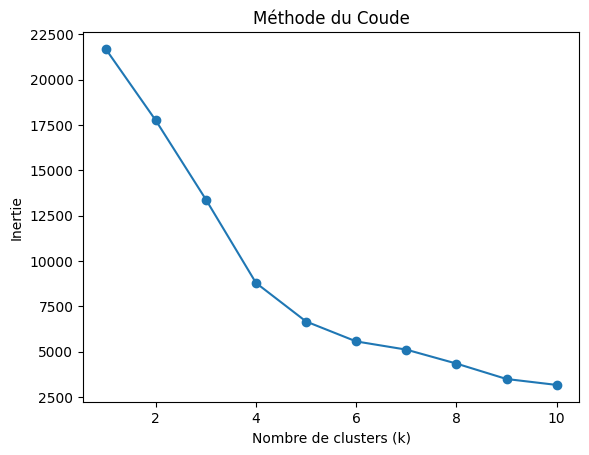

In [14]:
from sklearn.cluster import KMeans

#le nombre optimal de clusters avec la "Méthode du Coude"
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Visualisation
import matplotlib.pyplot as plt
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du Coude')
plt.show()

In [20]:
k= 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)

# Ajout des labels au DataFrame
client_df['Segment'] = kmeans.labels_

silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
print(f"Score de silhouette: {silhouette_avg:.2f}")  # Entre -1 et 1 (plus proche de 1 = mieux)

Score de silhouette: 0.51


In [21]:
# Calcul des valeurs de silhouette pour chaque échantillon
silhouette_values = silhouette_samples(X_scaled, kmeans.labels_)

# Affichage du score moyen par cluster
for i in range(k):  # k = nombre de clusters
    cluster_silhouette = silhouette_values[kmeans.labels_ == i]
    print(f"Cluster {i}: Score moyen = {np.mean(cluster_silhouette):.3f} | Taille = {len(cluster_silhouette)}")

Cluster 0: Score moyen = 0.560 | Taille = 2842
Cluster 1: Score moyen = 0.536 | Taille = 1052
Cluster 2: Score moyen = 0.756 | Taille = 2
Cluster 3: Score moyen = 0.120 | Taille = 432
Cluster 4: Score moyen = 0.080 | Taille = 10


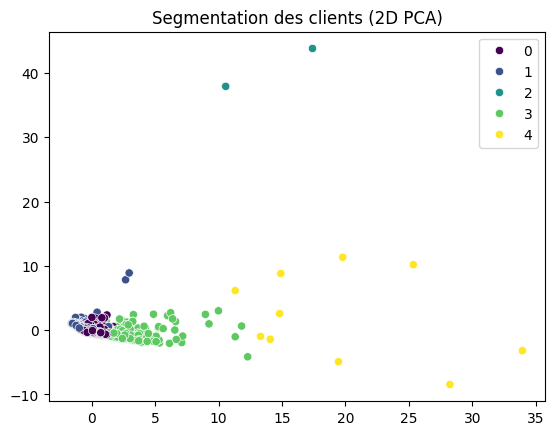

In [22]:
# Avec PCA (2D)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans.labels_, palette='viridis')
plt.title('Segmentation des clients (2D PCA)')
plt.show()

In [23]:
client_df.groupby('Segment').agg({
    'Récence': ['mean', 'median'],
    'Fréquence': ['mean', 'count'],
    'CA_total': ['sum', 'mean']
})

Récence         Fréquence           CA_total               
               mean median       mean count          sum           mean
Segment                                                                
0         46.187192   36.0   3.352569  2842  3353123.563    1179.846433
1        249.758555  246.0   1.568441  1052   578211.901     549.631085
2        163.500000  163.5   1.500000     2   245656.100  122828.050000
3         16.280093   10.0  14.754630   432  3419577.980    7915.689769
4          5.300000    2.0  97.700000    10  1314838.360  131483.836000

Génerations des nouveaux échantillons pour la classe 2 et la classe 4 

In [59]:
def augment_class(data, target_class, n_samples):
    class_data = data[data['Segment']== target_class]
    augmented_samples= []
    
    for _ in range(n_samples):
        sample1= class_data.sample(1).iloc[0]
        sample2= class_data.sample(1).iloc[0]
        
        new_sample = {}
        for col in ['Récence', 'Fréquence', 'CA_total']:
            alpha= np.random.random()
            new_sample[col]= alpha*sample1[col] + (1 - alpha)*sample2[col]
            new_sample['Segment']= target_class
            augmented_samples.append(new_sample)
    return pd.DataFrame(augmented_samples)

In [60]:
# Générations de nouveaux échantillons
class_2_augmented = augment_class(client_df,2, 50)
class_4_augmented = augment_class(client_df,4, 50)

In [61]:
client_df_augmented = pd.concat([client_df, class_2_augmented, class_4_augmented], ignore_index= True)

In [65]:
client_df_augmented.groupby('Segment').agg({
    'Récence': ['mean', 'median'],
    'Fréquence': ['mean', 'count'],
    'CA_total': ['sum', 'mean']
})

Récence               Fréquence            CA_total               
               mean      median        mean count           sum           mean
Segment                                                                       
0         46.187192   36.000000    3.352569  2842  3.353124e+06    1179.846433
1        249.758555  246.000000    1.568441  1052  5.782119e+05     549.631085
2        165.278354  182.240639    1.494834   152  1.847813e+07  121566.617701
3         16.280093   10.000000   14.754630   432  3.419578e+06    7915.689769
4          4.006960    2.091602  107.806949   160  1.999502e+07  124968.862042

In [67]:
# Préparation des données
def prepare_data(df):
    # Encodage de la variable cible si nécessaire
    if df['Segment'].dtype == 'object':
        le = LabelEncoder()
        df['Segment'] = le.fit_transform(df['Segment'])
    
    X = df[['Récence', 'Fréquence', 'CA_total']].values
    y = df['Segment'].values
    
    # Normalisation
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y, scaler

X, y, scaler = prepare_data(client_df_augmented)

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.weights1 = np.random.randn(input_size, hidden_size) * 0.1
        self.bias1 = np.zeros((1, hidden_size))
        self.weights2 = np.random.randn(hidden_size, output_size) * 0.1
        self.bias2 = np.zeros((1, output_size))
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        self.hidden = self.sigmoid(np.dot(X, self.weights1) + self.bias1)
        self.output = self.softmax(np.dot(self.hidden, self.weights2) + self.bias2)
        return self.output
    
    def backward(self, X, y, output, learning_rate=0.01):
        m = X.shape[0]
        
        # Calcul des gradients
        output_error = output - y
        hidden_error = output_error.dot(self.weights2.T) * (self.hidden * (1 - self.hidden))
        
        # Mise à jour des poids
        self.weights2 -= learning_rate * self.hidden.T.dot(output_error) / m
        self.bias2 -= learning_rate * np.sum(output_error, axis=0, keepdims=True) / m
        self.weights1 -= learning_rate * X.T.dot(hidden_error) / m
        self.bias1 -= learning_rate * np.sum(hidden_error, axis=0, keepdims=True) / m
    
    def train(self, X, y, epochs=1000, learning_rate=0.01):
        # One-hot encoding
        y_onehot = np.eye(len(np.unique(y)))[y]
        
        for epoch in range(epochs):
            # Forward pass
            output = self.forward(X)
            
            # Backward pass
            self.backward(X, y_onehot, output, learning_rate)
            
            if epoch % 100 == 0:
                loss = -np.mean(np.log(output[np.arange(len(y)), y]))
                accuracy = np.mean(np.argmax(output, axis=1) == y)
                print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
    
    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)
    
    def get_weights(self):
        return {
            'weights1': self.weights1,
            'bias1': self.bias1,
            'weights2': self.weights2,
            'bias2': self.bias2
        }

In [91]:
# Création et entraînement du réseau
input_size = 3
hidden_size = 4
output_size = len(np.unique(y))

nn = NeuralNetwork(input_size, hidden_size, output_size)
nn.train(X_train, y_train, epochs=1000, learning_rate=0.27)

# Évaluation
train_preds = nn.predict(X_train)
test_preds = nn.predict(X_test)

print(f"Train accuracy: {np.mean(train_preds == y_train):.4f}")
print(f"Test accuracy: {np.mean(test_preds == y_test):.4f}")

Epoch 0, Loss: 1.5102, Accuracy: 0.6175
Epoch 100, Loss: 0.8485, Accuracy: 0.6175
Epoch 200, Loss: 0.5609, Accuracy: 0.8237
Epoch 300, Loss: 0.4610, Accuracy: 0.8655
Epoch 400, Loss: 0.4031, Accuracy: 0.8695
Epoch 500, Loss: 0.3601, Accuracy: 0.8701
Epoch 600, Loss: 0.3263, Accuracy: 0.8776
Epoch 700, Loss: 0.2997, Accuracy: 0.8868
Epoch 800, Loss: 0.2793, Accuracy: 0.9019
Epoch 900, Loss: 0.2638, Accuracy: 0.9062
Train accuracy: 0.9116
Test accuracy: 0.9062


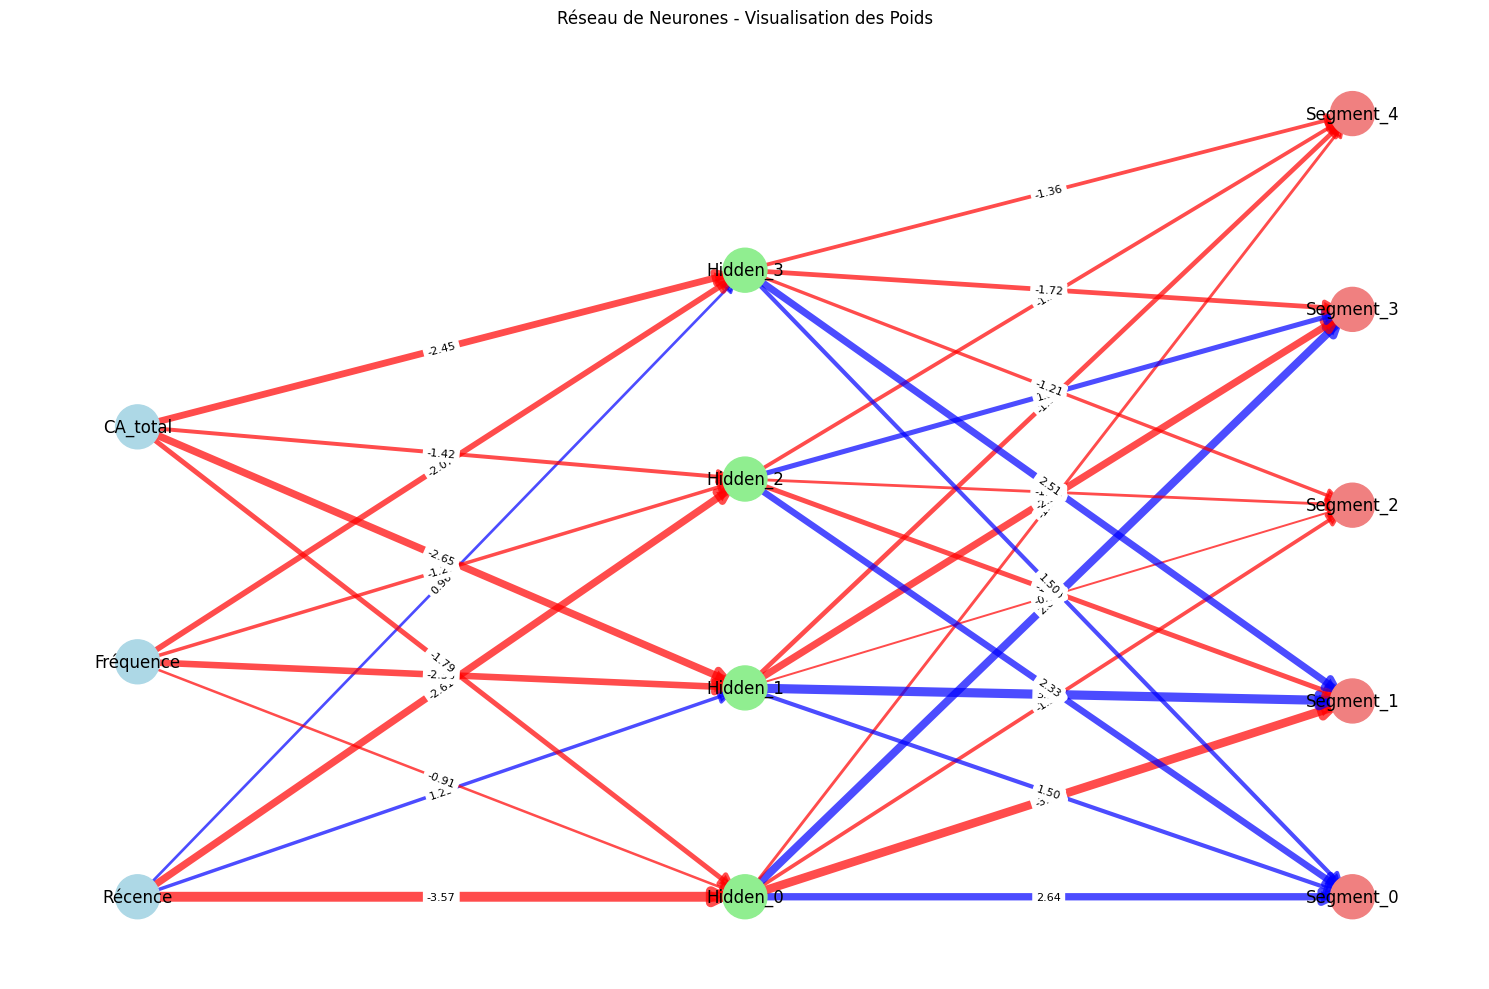

In [92]:
def visualize_neural_network(weights_dict, feature_names=None, class_names=None):
    G = nx.DiGraph()
    
    weights1 = weights_dict['weights1']
    bias1 = weights_dict['bias1']
    weights2 = weights_dict['weights2']
    bias2 = weights_dict['bias2']
    
    # Noms des features
    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(weights1.shape[0])]
    
    # Noms des classes
    if class_names is None:
        class_names = [f'Class_{i}' for i in range(weights2.shape[1])]
    
    # Couches
    input_nodes = feature_names
    hidden_nodes = [f'Hidden_{i}' for i in range(weights1.shape[1])]
    output_nodes = class_names
    
    # Ajout des nodes
    for node in input_nodes:
        G.add_node(node, layer='input', color='lightblue')
    
    for node in hidden_nodes:
        G.add_node(node, layer='hidden', color='lightgreen')
    
    for node in output_nodes:
        G.add_node(node, layer='output', color='lightcoral')
    
    # Connexions input -> hidden
    for i, input_node in enumerate(input_nodes):
        for j, hidden_node in enumerate(hidden_nodes):
            weight = weights1[i, j]
            G.add_edge(input_node, hidden_node, weight=weight, color='blue' if weight > 0 else 'red')
    
    # Connexions hidden -> output
    for i, hidden_node in enumerate(hidden_nodes):
        for j, output_node in enumerate(output_nodes):
            weight = weights2[i, j]
            G.add_edge(hidden_node, output_node, weight=weight, color='blue' if weight > 0 else 'red')
    
    # Visualisation
    plt.figure(figsize=(15, 10))
    pos = {}
    
    # Position des nodes
    layer_gap = 3
    input_y_pos = np.linspace(0, len(input_nodes), len(input_nodes))
    hidden_y_pos = np.linspace(0, len(hidden_nodes), len(hidden_nodes))
    output_y_pos = np.linspace(0, len(output_nodes), len(output_nodes))
    
    for i, node in enumerate(input_nodes):
        pos[node] = (0, input_y_pos[i])
    
    for i, node in enumerate(hidden_nodes):
        pos[node] = (layer_gap, hidden_y_pos[i])
    
    for i, node in enumerate(output_nodes):
        pos[node] = (2 * layer_gap, output_y_pos[i])
    
    # Couleurs des nodes
    node_colors = [G.nodes[node]['color'] for node in G.nodes()]
    
    # Couleurs des edges basées sur le poids
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]
    edge_weights = [abs(G[u][v]['weight']) * 2 for u, v in G.edges()]
    
    # Dessin du réseau
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1000)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_weights, 
                          arrows=True, arrowsize=20, alpha=0.7)
    
    # Ajout des labels de poids
    edge_labels = {(u, v): f'{G[u][v]["weight"]:.2f}' for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title('Réseau de Neurones - Visualisation des Poids')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return G

# Récupération des poids
weights = nn.get_weights()

# Visualisation
feature_names = ['Récence', 'Fréquence', 'CA_total']
class_names = [f'Segment_{i}' for i in range(output_size)]

network_graph = visualize_neural_network(weights, feature_names, class_names)

In [93]:
def analyze_weights(weights_dict, feature_names):
    print("=== ANALYSE DES POIDS ===")
    
    # Importance des features dans la couche cachée
    print("\nImportance des features dans la couche cachée:")
    for i, feature in enumerate(feature_names):
        importance = np.mean(np.abs(weights_dict['weights1'][i]))
        print(f"{feature}: {importance:.4f}")
    
    # Poids les plus significatifs
    print("\nPoids les plus forts (input -> hidden):")
    max_weights = np.unravel_index(np.argmax(np.abs(weights_dict['weights1'])), weights_dict['weights1'].shape)
    print(f"Feature {feature_names[max_weights[0]]} -> Hidden {max_weights[1]}: {weights_dict['weights1'][max_weights]:.4f}")
    
    print("\nPoids les plus forts (hidden -> output):")
    max_weights = np.unravel_index(np.argmax(np.abs(weights_dict['weights2'])), weights_dict['weights2'].shape)
    print(f"Hidden {max_weights[0]} -> Class {max_weights[1]}: {weights_dict['weights2'][max_weights]:.4f}")

analyze_weights(weights, feature_names)

=== ANALYSE DES POIDS ===

Importance des features dans la couche cachée:
Récence: 2.0966
Fréquence: 1.6535
CA_total: 2.0802

Poids les plus forts (input -> hidden):
Feature Récence -> Hidden 0: -3.5681

Poids les plus forts (hidden -> output):
Hidden 1 -> Class 1: 3.2975


In [96]:
class NeuralNetworkValidator:
    def __init__(self, model, X_test, y_test):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = model.predict(X_test)
        self.y_proba = model.forward(X_test)
    
    def calculate_metrics(self):
        """Calcule toutes les métriques de validation"""
        metrics = {}
        
        # Accuracy
        metrics['accuracy'] = np.mean(self.y_pred == self.y_test)
        
        # Precision, Recall, F1-score
        precision, recall, f1, _ = precision_recall_fscore_support(
            self.y_test, self.y_pred, average='weighted', zero_division=0
        )
        metrics['precision'] = precision
        metrics['recall'] = recall
        metrics['f1_score'] = f1
        
        # Matrice de confusion
        metrics['confusion_matrix'] = confusion_matrix(self.y_test, self.y_pred)
        
        # Perte (cross-entropy)
        y_onehot = np.eye(len(np.unique(self.y_test)))[self.y_test]
        metrics['loss'] = -np.mean(np.log(self.y_proba[np.arange(len(self.y_test)), self.y_test] + 1e-10))
        
        # Métriques par classe
        metrics['class_report'] = classification_report(self.y_test, self.y_pred, output_dict=True)
        
        return metrics
    
    def plot_confusion_matrix(self, class_names=None):
        """Visualise la matrice de confusion"""
        cm = self.calculate_metrics()['confusion_matrix']
        
        if class_names is None:
            class_names = [f'Class {i}' for i in range(len(np.unique(self.y_test)))]
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Matrice de Confusion')
        plt.ylabel('Vraie étiquette')
        plt.xlabel('Prédiction')
        plt.show()
    
    def plot_loss_curve(self, history):
        """Courbe d'apprentissage de la perte"""
        plt.figure(figsize=(10, 6))
        plt.plot(history['loss'], label='Perte d\'entraînement')
        plt.plot(history['val_loss'], label='Perte de validation')
        plt.title('Courbe d\'Apprentissage - Perte')
        plt.xlabel('Époques')
        plt.ylabel('Perte')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_accuracy_curve(self, history):
        """Courbe d'apprentissage de l'accuracy"""
        plt.figure(figsize=(10, 6))
        plt.plot(history['accuracy'], label='Accuracy d\'entraînement')
        plt.plot(history['val_accuracy'], label='Accuracy de validation')
        plt.title('Courbe d\'Apprentissage - Accuracy')
        plt.xlabel('Époques')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def print_detailed_report(self):
        """Affiche un rapport détaillé"""
        metrics = self.calculate_metrics()
        
        print("=" * 60)
        print("RAPPORT DE VALIDATION DU RÉSEAU DE NEURONES")
        print("=" * 60)
        
        print(f"\nMétriques Globales:")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-Score: {metrics['f1_score']:.4f}")
        print(f"Perte: {metrics['loss']:.4f}")
        
        print(f"\nMatrice de Confusion:")
        print(metrics['confusion_matrix'])
        
        print(f"\nRapport par Classe:")
        class_report = metrics['class_report']
        for class_name in [str(i) for i in range(len(np.unique(self.y_test)))]:
            if class_name in class_report:
                print(f"\nClasse {class_name}:")
                print(f"  Precision: {class_report[class_name]['precision']:.4f}")
                print(f"  Recall: {class_report[class_name]['recall']:.4f}")
                print(f"  F1-Score: {class_report[class_name]['f1-score']:.4f}")
                print(f"  Support: {class_report[class_name]['support']}")

# Modification de la classe NeuralNetwork pour inclure l'historique
class NeuralNetworkWithHistory(NeuralNetwork):
    def train(self, X, y, X_val=None, y_val=None, epochs=1000, learning_rate=0.01):
        y_onehot = np.eye(len(np.unique(y)))[y]
        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
        
        for epoch in range(epochs):
            # Forward pass
            output = self.forward(X)
            
            # Backward pass
            self.backward(X, y_onehot, output, learning_rate)
            
            if epoch % 10 == 0:
                # Calcul des métriques d'entraînement
                loss = -np.mean(np.log(output[np.arange(len(y)), y] + 1e-10))
                accuracy = np.mean(np.argmax(output, axis=1) == y)
                history['loss'].append(loss)
                history['accuracy'].append(accuracy)
                
                # Calcul des métriques de validation si données fournies
                if X_val is not None and y_val is not None:
                    val_output = self.forward(X_val)
                    val_loss = -np.mean(np.log(val_output[np.arange(len(y_val)), y_val] + 1e-10))
                    val_accuracy = np.mean(np.argmax(val_output, axis=1) == y_val)
                    history['val_loss'].append(val_loss)
                    history['val_accuracy'].append(val_accuracy)
                
                if epoch % 100 == 0:
                    print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        
        return history

In [97]:
def cross_validate_neural_network(X, y, k_folds=5, hidden_size=4, epochs=500):
    """Validation croisée k-fold"""
    from sklearn.model_selection import KFold
    
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_metrics = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n=== Fold {fold + 1}/{k_folds} ===")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Entraînement
        nn = NeuralNetworkWithHistory(X.shape[1], hidden_size, len(np.unique(y)))
        history = nn.train(X_train, y_train, X_val, y_val, epochs=epochs)
        
        # Validation
        validator = NeuralNetworkValidator(nn, X_val, y_val)
        metrics = validator.calculate_metrics()
        fold_metrics.append(metrics)
        
        print(f"Fold {fold + 1} - Accuracy: {metrics['accuracy']:.4f}")
    
    # Métriques moyennes
    avg_metrics = {
        'accuracy': np.mean([m['accuracy'] for m in fold_metrics]),
        'precision': np.mean([m['precision'] for m in fold_metrics]),
        'recall': np.mean([m['recall'] for m in fold_metrics]),
        'f1_score': np.mean([m['f1_score'] for m in fold_metrics]),
        'loss': np.mean([m['loss'] for m in fold_metrics])
    }
    
    return avg_metrics, fold_metrics

Epoch 0, Loss: 1.6553, Accuracy: 0.0350


Epoch 100, Loss: 0.7651, Accuracy: 0.7596
Epoch 200, Loss: 0.5605, Accuracy: 0.8280
Epoch 300, Loss: 0.4808, Accuracy: 0.8318
Epoch 400, Loss: 0.4294, Accuracy: 0.8679
Epoch 500, Loss: 0.3884, Accuracy: 0.8693
Epoch 600, Loss: 0.3523, Accuracy: 0.8709
Epoch 700, Loss: 0.3219, Accuracy: 0.8776
Epoch 800, Loss: 0.2973, Accuracy: 0.8871
Epoch 900, Loss: 0.2780, Accuracy: 0.9027
RAPPORT DE VALIDATION DU RÉSEAU DE NEURONES

Métriques Globales:
Accuracy: 0.9041
Precision: 0.9135
Recall: 0.9041
F1-Score: 0.8876
Perte: 0.2654

Matrice de Confusion:
[[546   2   0   3   0]
 [  4 224   0   0   0]
 [  0   0   9   1  22]
 [ 57   0   0  30   0]
 [  0   0   0   0  30]]

Rapport par Classe:

Classe 0:
  Precision: 0.8995
  Recall: 0.9909
  F1-Score: 0.9430
  Support: 551.0

Classe 1:
  Precision: 0.9912
  Recall: 0.9825
  F1-Score: 0.9868
  Support: 228.0

Classe 2:
  Precision: 1.0000
  Recall: 0.2812
  F1-Score: 0.4390
  Support: 32.0

Classe 3:
  Precision: 0.8824
  Recall: 0.3448
  F1-Score: 0.495

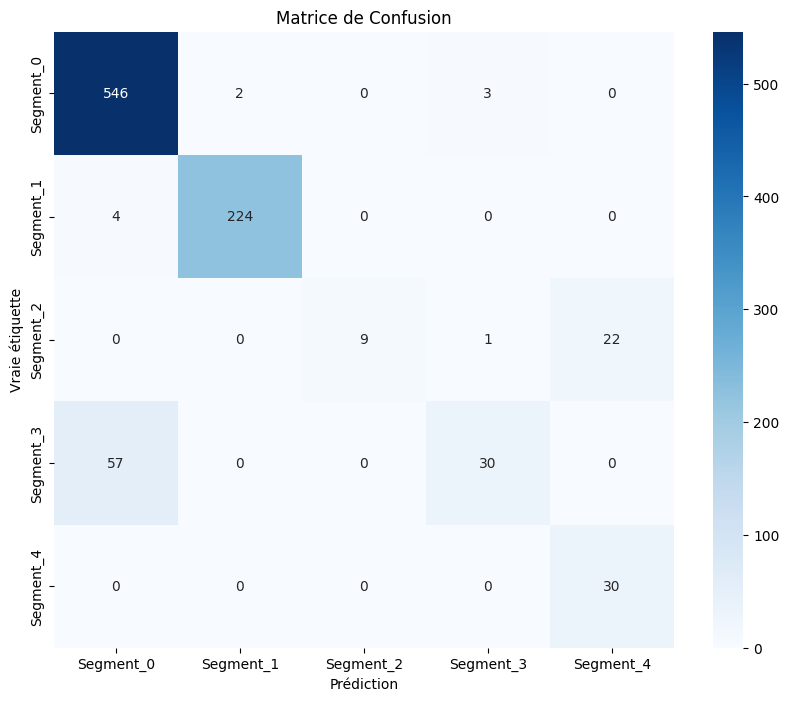

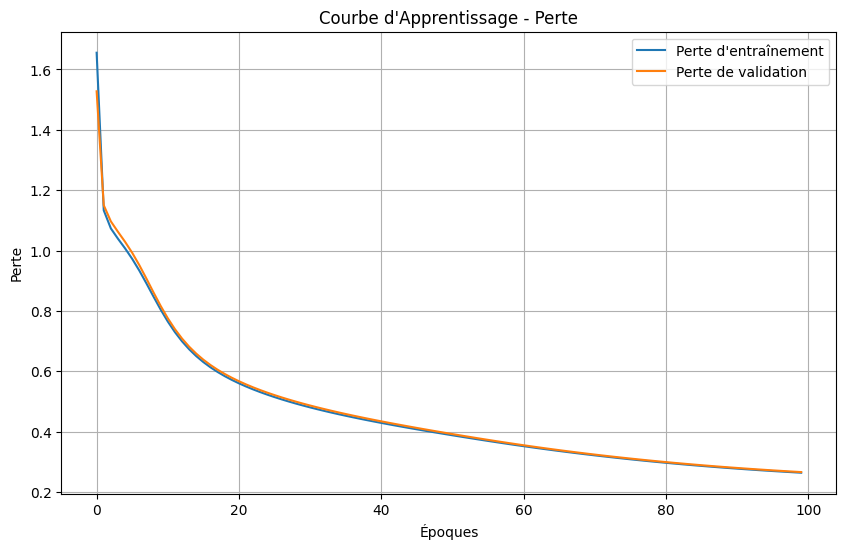

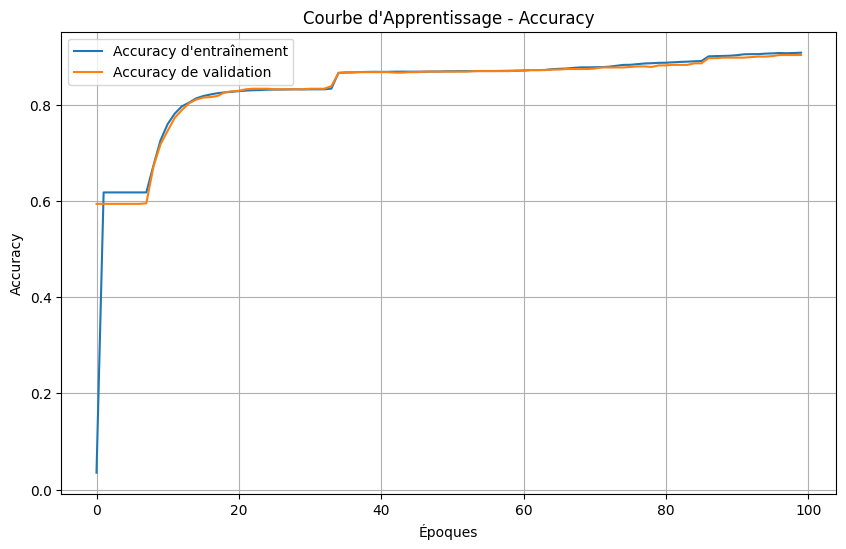


VALIDATION CROISÉE 5-FOLD

=== Fold 1/5 ===
Epoch 0, Loss: 1.5618, Accuracy: 0.0930
Epoch 100, Loss: 1.2672, Accuracy: 0.6175
Epoch 200, Loss: 1.1582, Accuracy: 0.6175
Epoch 300, Loss: 1.1131, Accuracy: 0.6175
Epoch 400, Loss: 1.0882, Accuracy: 0.6175


c:\Users\Dimbisoa Nomena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dimbisoa Nomena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dimbisoa Nomena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Fold 1 - Accuracy: 0.5938

=== Fold 2/5 ===
Epoch 0, Loss: 1.6373, Accuracy: 0.0903
Epoch 100, Loss: 1.2994, Accuracy: 0.6089
Epoch 200, Loss: 1.1729, Accuracy: 0.6089
Epoch 300, Loss: 1.1222, Accuracy: 0.6089
Epoch 400, Loss: 1.0961, Accuracy: 0.6089


c:\Users\Dimbisoa Nomena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dimbisoa Nomena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dimbisoa Nomena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Fold 2 - Accuracy: 0.6282

=== Fold 3/5 ===
Epoch 0, Loss: 1.5804, Accuracy: 0.2305
Epoch 100, Loss: 1.2743, Accuracy: 0.6137
Epoch 200, Loss: 1.1588, Accuracy: 0.6137
Epoch 300, Loss: 1.1111, Accuracy: 0.6137
Epoch 400, Loss: 1.0857, Accuracy: 0.6137


c:\Users\Dimbisoa Nomena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dimbisoa Nomena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dimbisoa Nomena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Fold 3 - Accuracy: 0.6088

=== Fold 4/5 ===
Epoch 0, Loss: 1.5617, Accuracy: 0.6128
Epoch 100, Loss: 1.2843, Accuracy: 0.6128
Epoch 200, Loss: 1.1789, Accuracy: 0.6128
Epoch 300, Loss: 1.1332, Accuracy: 0.6128
Epoch 400, Loss: 1.1081, Accuracy: 0.6128


c:\Users\Dimbisoa Nomena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dimbisoa Nomena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dimbisoa Nomena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Fold 4 - Accuracy: 0.6127

=== Fold 5/5 ===
Epoch 0, Loss: 1.6423, Accuracy: 0.2231
Epoch 100, Loss: 1.3032, Accuracy: 0.6109
Epoch 200, Loss: 1.1767, Accuracy: 0.6109
Epoch 300, Loss: 1.1271, Accuracy: 0.6109
Epoch 400, Loss: 1.1017, Accuracy: 0.6109
Fold 5 - Accuracy: 0.6203

Métriques moyennes sur 5 folds:
Accuracy: 0.6128 ± 0.0116
Precision: 0.3756 ± 0.0142
Recall: 0.6128 ± 0.0116
F1-Score: 0.4657 ± 0.0143


c:\Users\Dimbisoa Nomena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dimbisoa Nomena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dimbisoa Nomena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [99]:
# Préparation des données
X, y, scaler = prepare_data(client_df_augmented)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement avec historique
nn = NeuralNetworkWithHistory(input_size=3, hidden_size=4, output_size=len(np.unique(y)))
history = nn.train(X_train, y_train, X_test, y_test, epochs=1000, learning_rate=0.27)

# Validation sur le test set
validator = NeuralNetworkValidator(nn, X_test, y_test)

# Affichage des résultats
validator.print_detailed_report()

# Visualisations
validator.plot_confusion_matrix(class_names=[f'Segment_{i}' for i in range(len(np.unique(y)))])
validator.plot_loss_curve(history)
validator.plot_accuracy_curve(history)

# Validation croisée
print("\n" + "="*60)
print("VALIDATION CROISÉE 5-FOLD")
print("="*60)
avg_metrics, fold_metrics = cross_validate_neural_network(X, y, k_folds=5, epochs=500)

print(f"\nMétriques moyennes sur 5 folds:")
print(f"Accuracy: {avg_metrics['accuracy']:.4f} ± {np.std([m['accuracy'] for m in fold_metrics]):.4f}")
print(f"Precision: {avg_metrics['precision']:.4f} ± {np.std([m['precision'] for m in fold_metrics]):.4f}")
print(f"Recall: {avg_metrics['recall']:.4f} ± {np.std([m['recall'] for m in fold_metrics]):.4f}")
print(f"F1-Score: {avg_metrics['f1_score']:.4f} ± {np.std([m['f1_score'] for m in fold_metrics]):.4f}")

In [100]:
def analyze_class_performance(validator):
    """Analyse détaillée des performances par classe"""
    metrics = validator.calculate_metrics()
    class_report = metrics['class_report']
    
    print("\nANALYSE DES PERFORMANCES PAR CLASSE:")
    print("-" * 50)
    
    for class_id in sorted([int(k) for k in class_report.keys() if k.isdigit()]):
        class_metrics = class_report[str(class_id)]
        print(f"Segment {class_id}:")
        print(f"  Precision: {class_metrics['precision']:.3f}")
        print(f"  Recall:    {class_metrics['recall']:.3f}")
        print(f"  F1-Score:  {class_metrics['f1-score']:.3f}")
        print(f"  Support:   {class_metrics['support']}")
        print()

# Exécution de l'analyse
analyze_class_performance(validator)


ANALYSE DES PERFORMANCES PAR CLASSE:
--------------------------------------------------
Segment 0:
  Precision: 0.900
  Recall:    0.991
  F1-Score:  0.943
  Support:   551.0

Segment 1:
  Precision: 0.991
  Recall:    0.982
  F1-Score:  0.987
  Support:   228.0

Segment 2:
  Precision: 1.000
  Recall:    0.281
  F1-Score:  0.439
  Support:   32.0

Segment 3:
  Precision: 0.882
  Recall:    0.345
  F1-Score:  0.496
  Support:   87.0

Segment 4:
  Precision: 0.577
  Recall:    1.000
  F1-Score:  0.732
  Support:   30.0



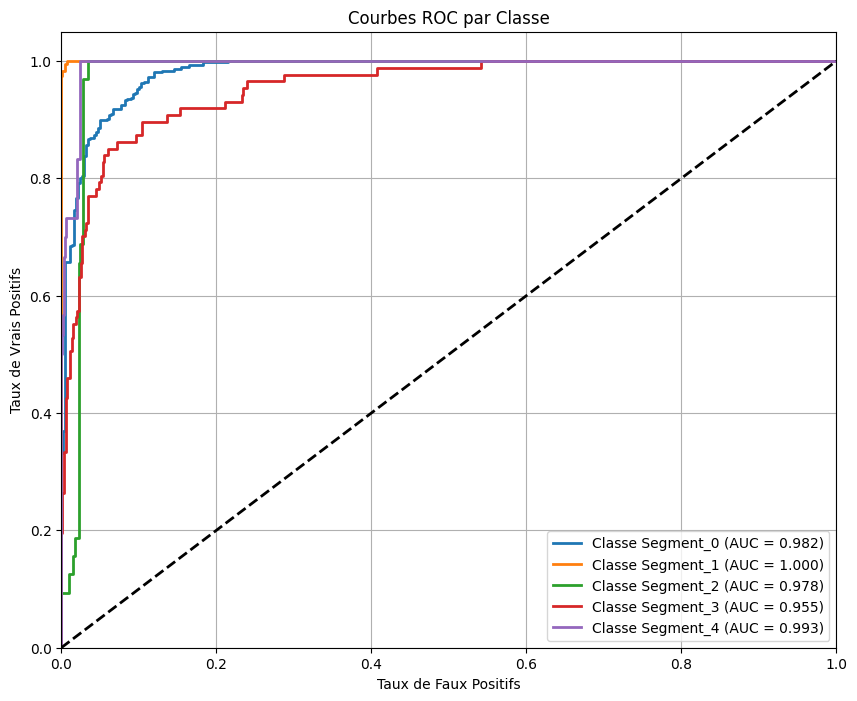

In [102]:
def plot_roc_curves(validator, class_names):
    """Courbes ROC pour chaque classe"""
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    
    y_test_bin = label_binarize(validator.y_test, classes=np.unique(validator.y_test))
    n_classes = y_test_bin.shape[1]
    
    plt.figure(figsize=(10, 8))
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], validator.y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, 
                label=f'Classe {class_names[i]} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs')
    plt.ylabel('Taux de Vrais Positifs')
    plt.title('Courbes ROC par Classe')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Pour une visualisation ROC (si multiclasse)
plot_roc_curves(validator, [f'Segment_{i}' for i in range(len(np.unique(y)))])

In [103]:
class ClientPredictor:
    def __init__(self, model, scaler, feature_names=None, class_names=None):
        self.model = model
        self.scaler = scaler
        self.feature_names = feature_names or ['Récence', 'Fréquence', 'CA_total']
        self.class_names = class_names or [f'Segment_{i}' for i in range(model.weights2.shape[1])]
    
    def predict_single_client(self, recence, frequence, ca_total):
        """Prédit la classe d'un seul client"""
        # Préparation des données
        client_data = np.array([[recence, frequence, ca_total]])
        client_data_scaled = self.scaler.transform(client_data)
        
        # Prédiction
        probabilities = self.model.forward(client_data_scaled)[0]
        predicted_class = np.argmax(probabilities)
        confidence = probabilities[predicted_class]
        
        return {
            'class': predicted_class,
            'class_name': self.class_names[predicted_class],
            'confidence': confidence,
            'probabilities': probabilities,
            'features': {
                'Récence': recence,
                'Fréquence': frequence,
                'CA_total': ca_total
            }
        }
    
    def predict_multiple_clients(self, clients_data):
        """Prédit les classes pour plusieurs clients"""
        if isinstance(clients_data, pd.DataFrame):
            # Extraction des features depuis un DataFrame
            X = clients_data[self.feature_names].values
        else:
            # Array numpy ou liste
            X = np.array(clients_data)
        
        # Normalisation
        X_scaled = self.scaler.transform(X)
        
        # Prédictions
        probabilities = self.model.forward(X_scaled)
        predictions = np.argmax(probabilities, axis=1)
        confidences = probabilities[np.arange(len(predictions)), predictions]
        
        results = []
        for i, (pred, conf, prob) in enumerate(zip(predictions, confidences, probabilities)):
            results.append({
                'client_id': i,
                'class': pred,
                'class_name': self.class_names[pred],
                'confidence': conf,
                'probabilities': prob,
                'features': dict(zip(self.feature_names, X[i]))
            })
        
        return results
    
    def predict_from_dataframe(self, df):
        """Prédit les classes à partir d'un DataFrame complet"""
        return self.predict_multiple_clients(df)
    
    def get_class_description(self, class_id):
        """Retourne une description du segment client"""
        descriptions = {
            0: "Clients réguliers - Fréquence moyenne, récence modérée",
            1: "Clients occasionnels - Faible fréquence, récence élevée",
            2: "Clients VIP - Très haute valeur, très rares",
            3: "Clients fidèles - Très haute fréquence, récence faible",
            4: "Clients premium - Fréquence très élevée, valeur exceptionnelle"
        }
        return descriptions.get(class_id, "Segment non défini")
    
    def visualize_prediction(self, prediction):
        """Visualise la prédiction avec un graphique"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Probabilités par classe
        classes = range(len(prediction['probabilities']))
        colors = ['lightblue' if i != prediction['class'] else 'red' for i in classes]
        
        ax1.bar(classes, prediction['probabilities'], color=colors, alpha=0.7)
        ax1.set_xlabel('Classes')
        ax1.set_ylabel('Probabilité')
        ax1.set_title(f'Probabilités de Classification\nClasse prédite: {prediction["class_name"]}')
        ax1.set_xticks(classes)
        ax1.set_xticklabels([f'Classe {i}' for i in classes])
        
        # 2. Features du client
        features = list(prediction['features'].keys())
        values = list(prediction['features'].values())
        
        ax2.bar(features, values, color='skyblue', alpha=0.7)
        ax2.set_title('Caractéristiques du Client')
        ax2.tick_params(axis='x', rotation=45)
        
        # 3. Cercle de confiance
        confidence = prediction['confidence']
        ax3.pie([confidence, 1-confidence], labels=['Confiance', 'Incertitude'], 
               colors=['green', 'lightgray'], autopct='%1.1f%%')
        ax3.set_title(f'Niveau de Confiance: {confidence:.2%}')
        
        # 4. Description du segment
        description = self.get_class_description(prediction['class'])
        ax4.text(0.1, 0.5, f"Segment: {prediction['class_name']}\n\n{description}", 
                fontsize=12, va='center', ha='left', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))
        ax4.axis('off')
        ax4.set_title('Description du Segment Client')
        
        plt.tight_layout()
        plt.show()
    
    def generate_prediction_report(self, predictions):
        """Génère un rapport complet des prédictions"""
        report = {
            'total_clients': len(predictions),
            'class_distribution': {},
            'average_confidence': np.mean([p['confidence'] for p in predictions]),
            'detailed_predictions': predictions
        }
        
        for pred in predictions:
            class_id = pred['class']
            if class_id not in report['class_distribution']:
                report['class_distribution'][class_id] = {
                    'count': 0,
                    'average_confidence': 0,
                    'class_name': pred['class_name']
                }
            report['class_distribution'][class_id]['count'] += 1
            report['class_distribution'][class_id]['average_confidence'] += pred['confidence']
        
        # Calcul des moyennes de confiance
        for class_id in report['class_distribution']:
            count = report['class_distribution'][class_id]['count']
            report['class_distribution'][class_id]['average_confidence'] /= count
            report['class_distribution'][class_id]['percentage'] = (count / len(predictions)) * 100
        
        return report
    
    def print_prediction_report(self, report):
        """Affiche le rapport de prédiction"""
        print("=" * 60)
        print("RAPPORT DE PRÉDICTION DES CLIENTS")
        print("=" * 60)
        print(f"Nombre total de clients: {report['total_clients']}")
        print(f"Confiance moyenne: {report['average_confidence']:.2%}")
        print("\nDistribution des segments:")
        print("-" * 40)
        
        for class_id, stats in sorted(report['class_distribution'].items()):
            print(f"{stats['class_name']}:")
            print(f"  Nombre: {stats['count']} ({stats['percentage']:.1f}%)")
            print(f"  Confiance moyenne: {stats['average_confidence']:.2%}")
            print(f"  Description: {self.get_class_description(class_id)}")
            print()

=== PRÉDICTION POUR UN CLIENT INDIVIDUEL ===
Classe prédite: Segment_0
Confiance: 93.09%
Probabilités: [0.9309294  0.0029161  0.00150445 0.06365149 0.00099856]


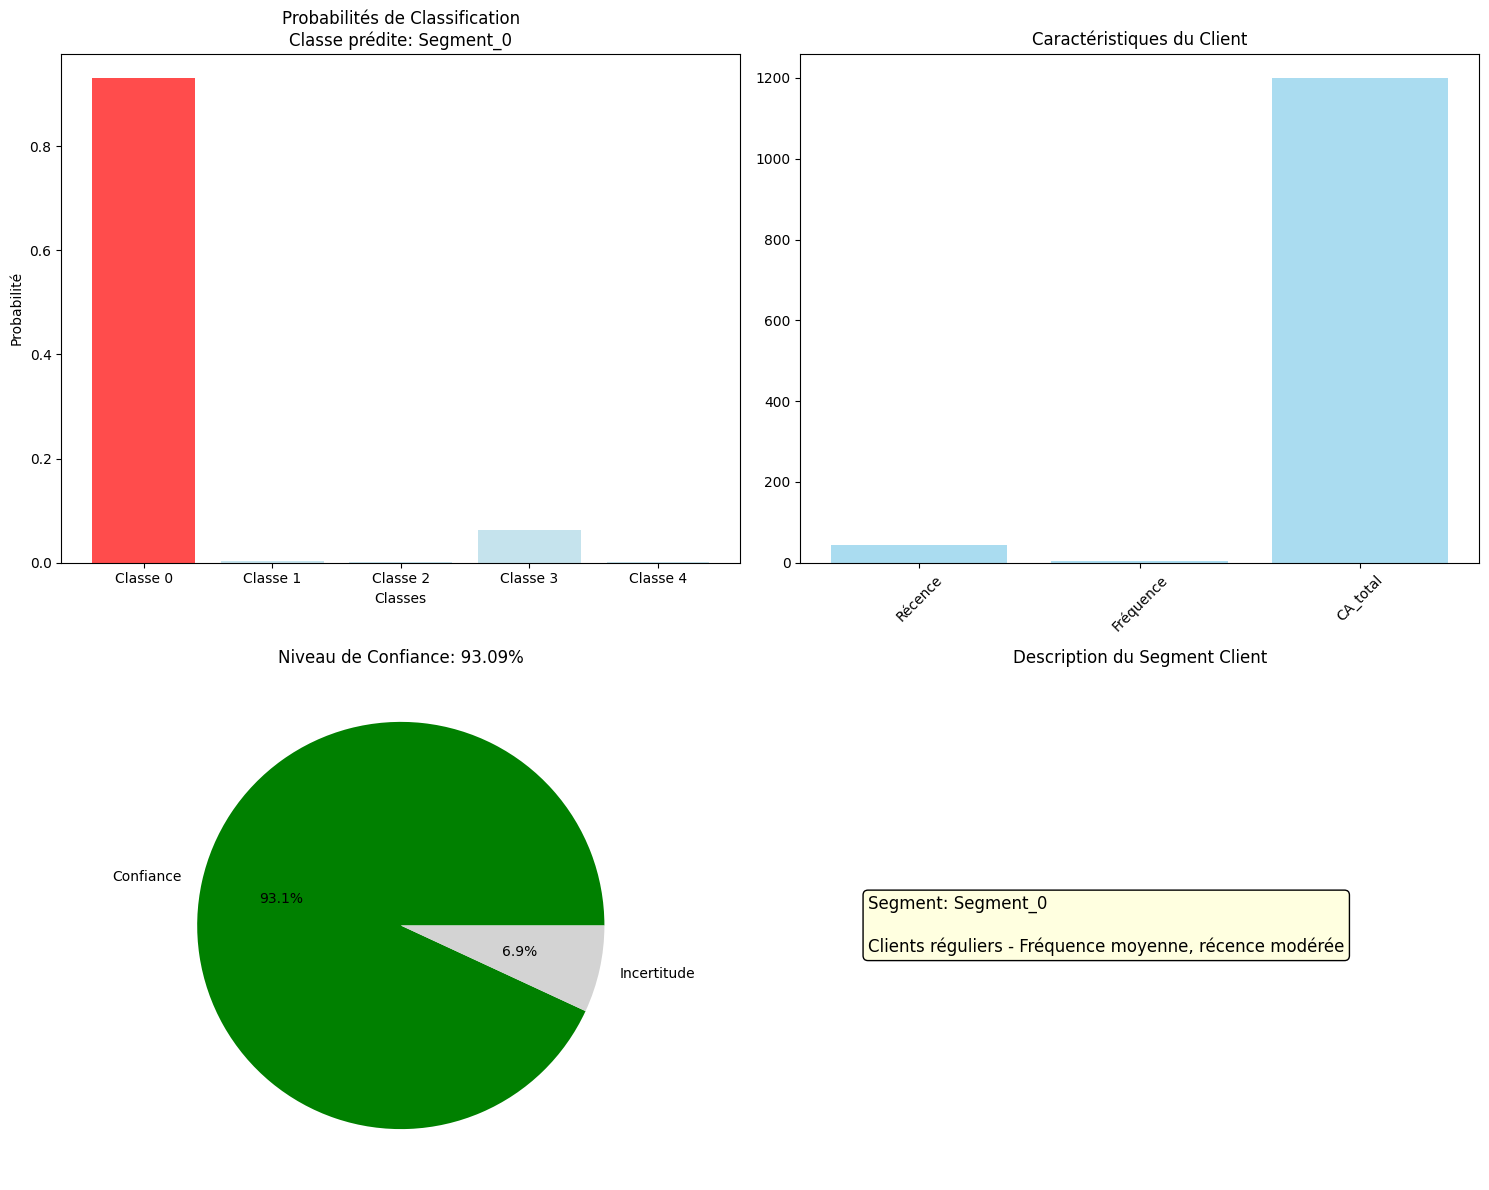


=== PRÉDICTION POUR PLUSIEURS CLIENTS ===
Client 1: Segment_0 (confiance: 89.94%)
Client 2: Segment_1 (confiance: 97.23%)
Client 3: Segment_3 (confiance: 53.53%)
Client 4: Segment_4 (confiance: 45.11%)
Client 5: Segment_1 (confiance: 67.66%)
RAPPORT DE PRÉDICTION DES CLIENTS
Nombre total de clients: 5
Confiance moyenne: 70.69%

Distribution des segments:
----------------------------------------
Segment_0:
  Nombre: 1 (20.0%)
  Confiance moyenne: 89.94%
  Description: Clients réguliers - Fréquence moyenne, récence modérée

Segment_1:
  Nombre: 2 (40.0%)
  Confiance moyenne: 82.44%
  Description: Clients occasionnels - Faible fréquence, récence élevée

Segment_3:
  Nombre: 1 (20.0%)
  Confiance moyenne: 53.53%
  Description: Clients fidèles - Très haute fréquence, récence faible

Segment_4:
  Nombre: 1 (20.0%)
  Confiance moyenne: 45.11%
  Description: Clients premium - Fréquence très élevée, valeur exceptionnelle



In [104]:
# Initialisation du prédicteur
predictor = ClientPredictor(nn, scaler, 
                           feature_names=['Récence', 'Fréquence', 'CA_total'],
                           class_names=[f'Segment_{i}' for i in range(len(np.unique(y)))])

# Prédiction pour un seul client
print("=== PRÉDICTION POUR UN CLIENT INDIVIDUEL ===")
single_prediction = predictor.predict_single_client(
    recence=45, 
    frequence=4, 
    ca_total=1200
)

print(f"Classe prédite: {single_prediction['class_name']}")
print(f"Confiance: {single_prediction['confidence']:.2%}")
print(f"Probabilités: {single_prediction['probabilities']}")

# Visualisation
predictor.visualize_prediction(single_prediction)

# Prédiction pour plusieurs clients
print("\n=== PRÉDICTION POUR PLUSIEURS CLIENTS ===")
multiple_clients = [
    [30, 5, 1500],    # Client 1
    [250, 1, 500],    # Client 2
    [10, 15, 8000],   # Client 3
    [5, 90, 120000],  # Client 4
    [160, 2, 300]     # Client 5
]

multiple_predictions = predictor.predict_multiple_clients(multiple_clients)

for i, pred in enumerate(multiple_predictions):
    print(f"Client {i+1}: {pred['class_name']} (confiance: {pred['confidence']:.2%})")

# Génération du rapport
report = predictor.generate_prediction_report(multiple_predictions)
predictor.print_prediction_report(report)

In [105]:
def predict_new_clients(new_clients_df):
    """
    Fonction principale pour prédire les classes de nouveaux clients
    """
    # Vérification des colonnes nécessaires
    required_columns = ['Récence', 'Fréquence', 'CA_total']
    missing_columns = [col for col in required_columns if col not in new_clients_df.columns]
    
    if missing_columns:
        raise ValueError(f"Colonnes manquantes: {missing_columns}")
    
    # Prédiction
    predictions = predictor.predict_from_dataframe(new_clients_df)
    
    # Ajout des prédictions au DataFrame
    result_df = new_clients_df.copy()
    result_df['Segment_Predit'] = [pred['class'] for pred in predictions]
    result_df['Segment_Nom'] = [pred['class_name'] for pred in predictions]
    result_df['Confiance'] = [pred['confidence'] for pred in predictions]
    
    return result_df, predictions

# Exemple d'utilisation avec un DataFrame
new_clients_data = {
    'Client_ID': ['C001', 'C002', 'C003', 'C004'],
    'Récence': [25, 260, 8, 3],
    'Fréquence': [6, 1, 20, 85],
    'CA_total': [1800, 400, 9500, 145000]
}

new_clients_df = pd.DataFrame(new_clients_data)

# Prédiction
result_df, detailed_predictions = predict_new_clients(new_clients_df)

print("Résultats de prédiction:")
print(result_df[['Client_ID', 'Récence', 'Fréquence', 'CA_total', 'Segment_Nom', 'Confiance']])

Résultats de prédiction:
  Client_ID  Récence  Fréquence  CA_total Segment_Nom  Confiance
0      C001       25          6      1800   Segment_0   0.871991
1      C002      260          1       400   Segment_1   0.974451
2      C003        8         20      9500   Segment_3   0.664738
3      C004        3         85    145000   Segment_4   0.451679
